### Download the dataset from Kaggle (requires kaggle.json)

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions list

!kaggle competitions download predict-volcanic-eruptions-ingv-oe
!unzip predict-volcanic-eruptions-ingv-oe.zip

### Sample Data
The following code block imports the necessary packages, acquires input files, and displays a sample of the segment data

In [109]:
import pandas as pd
import numpy as np

train_data = '../content/train/'
test_data = '../content/test/'
train = pd.read_csv('../content/train.csv')
submission = pd.read_csv('../content/sample_submission.csv')

segment_1 = pd.read_csv(train_data + '1000015382.csv')
segment_1.plot(subplots = True, layout = (5,2), figsize = (20,15))
plt.show()

###Preprocessing
I decided to write a function that loops through each segment of data from the training and testing directories and averages each column of sensor data. This simplifies the data by shrinking it all down from 60000 readings to 1.

Then, I combined all the data and replaced any null values with the average.

In [53]:
def compileDataFrame(data_dir='train'):
    dir = train_data if data_dir is 'train' else test_data
    segment_file = train if data_dir is 'train' else submission
    
    dataFrame = pd.DataFrame()
    for index in range(segment_file.shape[0]):
        data = pd.read_csv(dir + str(segment_file.segment_id.iloc[index]) + '.csv')

        if data_dir is 'train':
            data['timetoerupt'] = train.time_to_eruption.iloc[index]
            sensors = data.drop('timetoerupt',1).columns
        else: # data_dir is 'test'
            sensors = data.columns
            
        # Set every sensor to the avarage of the column
        for sensor in sensors:
            data[sensor] = data[sensor].mean()
        
        # Concats a single row sample to the dataFrame since every row is the same
        dataFrame = pd.concat([data.sample(), dataFrame])
        
        print('Segment: ' + str(index))
        print(dataFrame)
    return dataFrame

In [ ]:
train_set = compileDataFrame()

In [ ]:
test_set = compileDataFrame('test')

In [73]:
# Change all null values to the mean of the column
for sensor in train_set:
    train_set[sensor] = train_set[sensor].replace(np.nan, train_set[sensor].mean())

for sensor in test_set:
    test_set[sensor] = test_set[sensor].replace(np.nan, test_set[sensor].mean())

all_features = pd.concat((train_set.iloc[:, :-1], test_set.iloc[:, :]))
all_features.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
307,-4.142848,0.138031,1.955217,0.241129,-1.577340,0.385694,1.526325,0.802537,-1.700145,-45.584790
5230,0.905818,1.428776,-0.648256,-2.339661,0.320345,6.707488,-3.654656,-0.003951,1.104332,-6.360564
17775,1.420993,0.446893,-1.197830,1.510475,-0.514108,-1.531391,1.858136,1.647323,-1.149198,-1.550374
34822,7.936884,1.428776,5.014233,-4.597357,3.721506,0.607590,1.506825,-4.511225,5.498189,10.939634
24425,0.906735,-3.658256,-0.751437,1.915551,-1.734333,-22.033699,1.607623,0.046333,-1.802253,-3.377394


In [74]:
feature_split = train_set.shape[0]
train_features = all_features[:feature_split].values.astype(float)
test_features = all_features[feature_split:].values.astype(float)
train_labels = train_set.timetoerupt.values.astype(float).reshape((-1, 1))

In [75]:
from torch.utils.data import Dataset, DataLoader

class EruptionDataset(Dataset):
    def __init__(self, train_features, train_labels):
        super().__init__()
        self.train_features = train_features
        self.train_labels = train_labels

    def __len__(self):
        return len(self.train_features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (self.train_features[idx], self.train_labels[idx])

### Deep Learning Method: MLP Solution

In [89]:
import torch
from torch import nn

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(128, 16),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(16, output_dim)
        )

    def forward(self, xb):
        xb = self.regressor(xb)
        return xb

In [87]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))

criterion = RMSELoss()

In [86]:
class Log_RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        clipped_preds = torch.clamp(yhat, 1, float('inf'))
        return torch.sqrt(self.mse(torch.log(clipped_preds), torch.log(y)))

criterion = Log_RMSELoss()

In [106]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, batch_size):
    train_ls, test_ls = [], []
    train_dataset = EruptionDataset(train_features, train_labels)
    train_iter = DataLoader(train_dataset, batch_size, shuffle=True)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = Log_RMSELoss()
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            yhat = net(X.float())
            loss = criterion(yhat, y.float())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_ls.append(loss)
        if test_labels is not None:
            test_ls.append(loss)
    return train_ls, test_ls

In [99]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = np.concatenate((X_train, X_part), axis=0)
            y_train = np.concatenate((y_train, y_part), axis=0)
    return X_train, y_train, X_valid, y_valid

In [100]:
## util function
from matplotlib import pyplot as plt
from IPython import display

def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    """Plot x and log(y)."""

    def set_figsize(figsize=(3.5, 2.5)):
        """Set matplotlib figure size."""
        display.set_matplotlib_formats('svg')
        plt.rcParams['figure.figsize'] = figsize

    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)
    plt.show()

In [101]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = MLP(all_features.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'mse',
                        range(1, num_epochs + 1), valid_ls,
                        ['train', 'valid'])
        print('fold %d, train mse: %f, valid mse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

In [107]:
# Hyperparameters
k = 5
num_epochs = 64
lr = 0.001
batch_size = 64

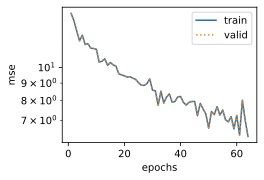

fold 0, train mse: 6.280359, valid mse: 6.280359
fold 1, train mse: 6.662563, valid mse: 6.662563
fold 2, train mse: 6.808138, valid mse: 6.808138
fold 3, train mse: 6.697483, valid mse: 6.697483
fold 4, train mse: 6.134801, valid mse: 6.134801
5-fold validation: avg train rmse: 6.516669, avg valid rmse: 6.516669


In [108]:
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
      % (k, train_l, valid_l))

In [104]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, batch_size):
    net = MLP(all_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, batch_size)
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
   
    preds = net(torch.from_numpy(test_features).float()).data.numpy()
    
    # Reformat output for export to Kaggle
    submission['time_to_eruption'] = preds
    submission.to_csv('submission.csv', index=False)

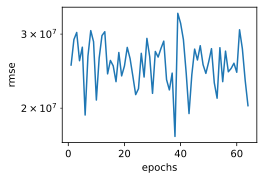

train rmse 20274494.000000


In [105]:
train_and_pred(train_features, test_features, train_labels, train_set,
               num_epochs, lr, batch_size)